In [36]:
# Dependencies and Setup
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from scipy.stats import linregress
import scipy.stats as st
from config import gkey

# gmaps.configure(api_key=gkey)

# Read the data
zips_df = pd.read_csv(r"resources/zip_code_data_cleaned.csv")
# unemployment_df = pd.read_csv(r"resources/KS_MO_Unemployment_Data_Cleaned.csv")
census_data_df = pd.read_csv(r"resources/census_data.csv")
ppp_data_df = pd.read_csv(r"resources/PPP Data Combined.csv")

# Combine the data into a single datasets
ppp_data_clean_df = ppp_data_df[["LoanRange","State","Zip","JobsReported","DateApproved"]]
ppp_data_clean_df = ppp_data_clean_df.rename(columns={"Zip":"Zipcode"})
ppp_data_clean_df.head()

,LoanRange,State,Zipcode,JobsReported,DateApproved
0,a $5-10 million,KS,67846,356.0,4/8/2020
1,a $5-10 million,KS,67206,500.0,4/4/2020
2,a $5-10 million,KS,66208,500.0,4/14/2020
3,a $5-10 million,KS,66210,279.0,4/4/2020
4,a $5-10 million,KS,66615,296.0,4/7/2020


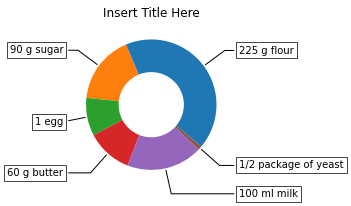

In [13]:
labels = ["225 g flour",
          "90 g sugar",
          "1 egg",
          "60 g butter",
          "100 ml milk",
          "1/2 package of yeast"]

sizes = [225, 90, 50, 60, 100, 5]

fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

wedges, texts = ax.pie(sizes, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Insert Title Here")

plt.show()

In [17]:
# Data files
zips_ks_path = "resources/raw data/ks_zipcodes.csv"
zips_mo_path = "resources/raw data/mo_zipcodes.csv"

# Read the data
zips_ks = pd.read_csv(zips_ks_path)
zips_mo = pd.read_csv(zips_mo_path)

# Combine the data into a single datasets
zips_df = pd.concat([zips_ks, zips_mo])
zips_df

,Zip Code,Zip Code Type,Zip Code Name,County
0,66002,Non-Unique,Atchison,Atchison
1,66006,Non-Unique,Baldwin City,Douglas
2,66007,Non-Unique,Basehor,Leavenworth
3,66008,Non-Unique,Bendena,Doniphan
4,66010,Non-Unique,Blue Mound,Linn
...,...,...,...,...
1153,65817,PO Box,Springfield,Greene
1154,65890,Unique,Springfield,Greene
1155,65897,Unique,Springfield,Greene
1156,65898,Unique,Springfield,Greene


In [6]:
census_data_df

,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Not Hispanic or Latino,Hispanic or Latino,White Alone,Black or African American Alone,American Indian and Alaska Native Alone,Asian Alone,Native Hawaiian and Other Pacific Islander Alone,Some Other Race Alone,Two or More Races,Two or More Races Including Some Other Race,"Two or More Races Excluding Some Other Race, and Three or More Races"
0,8518,5217.0,41.5,74286.0,33963.0,170.0,3.258578,4928.0,289.0,3774.0,755.0,0.0,439.0,0.0,148.0,101.0,13.0,88.0
1,8520,27468.0,37.4,90293.0,37175.0,1834.0,6.676860,20887.0,6581.0,18000.0,1428.0,79.0,4117.0,17.0,2993.0,834.0,296.0,538.0
2,8525,4782.0,47.1,118656.0,59848.0,43.0,0.899205,4717.0,65.0,4481.0,142.0,0.0,108.0,0.0,1.0,50.0,3.0,47.0
3,8527,54867.0,42.2,88588.0,37021.0,2191.0,3.993293,50112.0,4755.0,48726.0,2807.0,23.0,1569.0,41.0,505.0,1196.0,334.0,862.0
4,8528,245.0,48.5,58676.0,49117.0,0.0,0.000000,245.0,0.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33115,99923,81.0,64.3,21944.0,17225.0,4.0,4.938272,81.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33116,99925,668.0,46.4,38125.0,25094.0,124.0,18.562874,649.0,19.0,344.0,3.0,239.0,4.0,0.0,0.0,78.0,0.0,78.0
33117,99926,1630.0,31.4,50052.0,22850.0,202.0,12.392638,1574.0,56.0,100.0,6.0,1362.0,2.0,3.0,0.0,157.0,0.0,157.0
33118,99927,111.0,59.4,19000.0,21157.0,39.0,35.135135,111.0,0.0,91.0,0.0,9.0,0.0,0.0,11.0,0.0,0.0,0.0


In [10]:
ppp_census_df = pd.merge(ppp_data_clean_df, census_data_df, on="Zipcode")
ppp_census_df

,LoanRange,State,Zipcode,JobsReported,DateApproved,Population,Median Age,Household Income,Per Capita Income,Poverty Count,...,Hispanic or Latino,White Alone,Black or African American Alone,American Indian and Alaska Native Alone,Asian Alone,Native Hawaiian and Other Pacific Islander Alone,Some Other Race Alone,Two or More Races,Two or More Races Including Some Other Race,"Two or More Races Excluding Some Other Race, and Three or More Races"
0,a $5-10 million,KS,67846,356.0,4/8/2020,33720.0,30.7,47011.0,21573.0,5500.0,...,16839.0,27262.0,791.0,249.0,1329.0,0.0,2933.0,1156.0,503.0,653.0
1,b $2-5 million,KS,67846,195.0,4/6/2020,33720.0,30.7,47011.0,21573.0,5500.0,...,16839.0,27262.0,791.0,249.0,1329.0,0.0,2933.0,1156.0,503.0,653.0
2,b $2-5 million,KS,67846,158.0,4/3/2020,33720.0,30.7,47011.0,21573.0,5500.0,...,16839.0,27262.0,791.0,249.0,1329.0,0.0,2933.0,1156.0,503.0,653.0
3,c $1-2 million,KS,67846,250.0,4/3/2020,33720.0,30.7,47011.0,21573.0,5500.0,...,16839.0,27262.0,791.0,249.0,1329.0,0.0,2933.0,1156.0,503.0,653.0
4,"d $350,000-1 million",KS,67846,61.0,4/3/2020,33720.0,30.7,47011.0,21573.0,5500.0,...,16839.0,27262.0,791.0,249.0,1329.0,0.0,2933.0,1156.0,503.0,653.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148772,1700,KS,66830,NaN,5/20/2020,177.0,52.2,43500.0,16394.0,45.0,...,21.0,160.0,0.0,0.0,0.0,0.0,4.0,13.0,0.0,13.0
148773,1504,KS,66830,1.0,6/15/2020,177.0,52.2,43500.0,16394.0,45.0,...,21.0,160.0,0.0,0.0,0.0,0.0,4.0,13.0,0.0,13.0
148774,1632,KS,66416,1.0,4/27/2020,607.0,45.0,56250.0,23617.0,27.0,...,11.0,571.0,0.0,7.0,7.0,0.0,0.0,22.0,0.0,22.0
148775,1500,KS,67341,1.0,4/15/2020,289.0,35.4,51250.0,19116.0,10.0,...,0.0,272.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,17.0


In [29]:
regression_df = pd.DataFrame({
    "Loans Issued": ppp_census_df.groupby("Zipcode").count()["State"],
    "Jobs Saved": ppp_data_clean_df.groupby("Zipcode").sum()["JobsReported"]
}).dropna()

x_values = regression_df["Loans Issued"]
y_values = regression_df["Jobs Saved"]

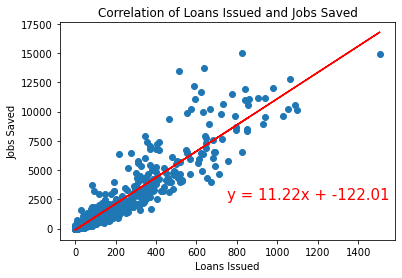

In [33]:
def plot_linear_regression(x_values, y_values, title, x_label, y_label, text_coordinates):
    # Run regression on hemisphere weather data.
    (slope, intercept, r_value, p_value, std_err) = linregress(x_values, y_values)
    # Calculate the regression line "y values" from the slope and intercept.
    regress_values = x_values * slope + intercept
    # Get the equation of the line.
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    # Create a scatter plot and plot the regression line.
    plt.scatter(x_values,y_values)
    plt.plot(x_values,regress_values,"r")
    # Annotate the text for the line equation.
    plt.annotate(line_eq, text_coordinates, fontsize=15, color="red")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

plot_linear_regression(x_values, y_values, "Correlation of Loans Issued and Jobs Saved", "Loans Issued", "Jobs Saved", (750,2500))